In [1]:
# use Avocado.csv
# use more than 1 algorithm (preferably 5)
# predict `Average Price`
# this is NOT  classification
# avocado prices in US, predict Average price
# can apply Simple imputer for missing values
# you need to deal with missing and categorical values
# bonus, if you can use a neural network (torch, keras etc)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
import os
import random

import kerastuner as kt

from keras.layers import Input
from bayes_opt import BayesianOptimization
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

def checkmissval(ds):
    missing_val_count_by_column = (ds.isnull().sum())
    return print(missing_val_count_by_column[missing_val_count_by_column > 0])

C:\Users\Owner\AppData\Local\Temp\ipykernel_21240\3282541342.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
import numpy as np
import pandas as pd

In [3]:
Avocado = pd.read_csv("Avocado.csv")

In [4]:
Avocado.head(10)

,Unnamed: 0,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
5,5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,conventional,2015,Albany
6,6,2015-11-15,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,conventional,2015,Albany
7,7,2015-11-08,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,conventional,2015,Albany
8,8,2015-11-01,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,conventional,2015,Albany
9,9,2015-10-25,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,conventional,2015,Albany


In [5]:
# MyTactic Dataset Preporation:
# drop column "Unnamed 0" - because it's seems like doubled index field,
# Use label encoder for column "region"
# Rename columns "4046","4225","4770"
# Convert column "type" to numeric
# Think about "Date" field

# drop column "Unnamed 0"

In [6]:
Avocado.drop("Unnamed: 0", axis=1, inplace=True)

# Rename columns "4046","4225","4770"

In [7]:
Avocado.rename(columns={'4046':'Small avocados',
                          '4225':'Large avocados',
                          '4770':'Extra Large avocados'}, 
                 inplace=True)


In [8]:
Avocado.head(10)

,Date,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
5,2015-11-22,1.26,55979.78,1184.27,48067.99,43.61,6683.91,6556.47,127.44,0.0,conventional,2015,Albany
6,2015-11-15,0.99,83453.76,1368.92,73672.72,93.26,8318.86,8196.81,122.05,0.0,conventional,2015,Albany
7,2015-11-08,0.98,109428.33,703.75,101815.36,80.00,6829.22,6266.85,562.37,0.0,conventional,2015,Albany
8,2015-11-01,1.02,99811.42,1022.15,87315.57,85.34,11388.36,11104.53,283.83,0.0,conventional,2015,Albany
9,2015-10-25,1.07,74338.76,842.40,64757.44,113.00,8625.92,8061.47,564.45,0.0,conventional,2015,Albany


In [9]:
Avocado.shape

(18249, 13)

In [10]:
Avocado.info() #seem's like we have lost data, tel's use imputer to fix it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  18249 non-null  object 
 1   AveragePrice          18249 non-null  float64
 2   TotalVolume           18248 non-null  float64
 3   Small avocados        18248 non-null  float64
 4   Large avocados        18249 non-null  float64
 5   Extra Large avocados  18249 non-null  float64
 6   TotalBags             18248 non-null  float64
 7   SmallBags             18249 non-null  float64
 8   LargeBags             18249 non-null  float64
 9   XLargeBags            18249 non-null  float64
 10  type                  18249 non-null  object 
 11  year                  18249 non-null  int64  
 12  region                18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [11]:
#yeap some value is missing and Date is object, not datetime format
checkmissval(Avocado)

TotalVolume       1
Small avocados    1
TotalBags         1
dtype: int64


# Think about "Date" field

In [12]:
Avocado['Date'] = pd.to_datetime(Avocado['Date'])
#Extract Month
Avocado['Date'][0].month
list_months = []
for i in range(Avocado.shape[0]):
    list_months.append(Avocado['Date'][i].month) 
Avocado['Month Value'] = list_months
#Extract Day
Avocado['Date'][500].weekday()
def date_to_weekday(date_value):
    return date_value.weekday()
Avocado['Day Value'] = Avocado['Date'].apply(date_to_weekday)
Avocado = Avocado.drop(['Date'], axis = 1)

In [13]:
Avocado

,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,Month Value,Day Value
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,6
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,6
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,6
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,2,6
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1,6
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1,6
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1,6


In [14]:
Avocado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AveragePrice          18249 non-null  float64
 1   TotalVolume           18248 non-null  float64
 2   Small avocados        18248 non-null  float64
 3   Large avocados        18249 non-null  float64
 4   Extra Large avocados  18249 non-null  float64
 5   TotalBags             18248 non-null  float64
 6   SmallBags             18249 non-null  float64
 7   LargeBags             18249 non-null  float64
 8   XLargeBags            18249 non-null  float64
 9   type                  18249 non-null  object 
 10  year                  18249 non-null  int64  
 11  region                18249 non-null  object 
 12  Month Value           18249 non-null  int64  
 13  Day Value             18249 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 1.9+ MB


In [15]:
#Lets impute data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent',
missing_values=np.nan)

imputer = imputer.fit(Avocado[['TotalVolume']])
Avocado[['TotalVolume']] = imputer.transform(Avocado[['TotalVolume']])
imputer = imputer.fit(Avocado[['Small avocados']])
Avocado[['Small avocados']] = imputer.transform(Avocado[['Small avocados']])
imputer = imputer.fit(Avocado[['TotalBags']])
Avocado[['TotalBags']] = imputer.transform(Avocado[['TotalBags']])

In [16]:
checkmissval(Avocado)

Series([], dtype: int64)


In [17]:
Avocado

,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,Month Value,Day Value
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,6
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,6
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,6
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,2,6
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1,6
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1,6
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1,6


# Convert column "type" to numeric

In [18]:
Avocado.type.unique()

array(['conventional', 'organic'], dtype=object)

In [19]:
#ok, now lets say conventional=0 and organic=1
Avocado = pd.get_dummies(Avocado, columns=['type'], drop_first=True)
Avocado.head()

,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,year,region,Month Value,Day Value,type_organic
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,Albany,12,6,False
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,Albany,12,6,False
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,Albany,12,6,False
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,Albany,12,6,False
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,Albany,11,6,False


In [20]:
Avocado.type_organic.unique()


array([False,  True])

In [21]:
Avocado['type_organic'].value_counts()

type_organic
False    9126
True     9123
Name: count, dtype: int64

# Use label encoder for column "region"

In [22]:
Avocado.head()

,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,year,region,Month Value,Day Value,type_organic
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,Albany,12,6,False
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,Albany,12,6,False
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,Albany,12,6,False
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,Albany,12,6,False
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,Albany,11,6,False


In [23]:
Avocado.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Avocado['region'] = label_encoder.fit_transform(Avocado['region'])
Avocado.region.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53])

In [25]:
Avocado.columns

Index(['AveragePrice', 'TotalVolume', 'Small avocados', 'Large avocados',
       'Extra Large avocados', 'TotalBags', 'SmallBags', 'LargeBags',
       'XLargeBags', 'year', 'region', 'Month Value', 'Day Value',
       'type_organic'],
      dtype='object')

In [26]:
x_data  = Avocado.drop('AveragePrice',axis=1)
y = Avocado['AveragePrice']

In [27]:
Avocado

,AveragePrice,TotalVolume,Small avocados,Large avocados,Extra Large avocados,TotalBags,SmallBags,LargeBags,XLargeBags,year,region,Month Value,Day Value,type_organic
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,0,12,6,False
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,0,12,6,False
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,0,12,6,False
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,0,12,6,False
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,0,11,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,2018,53,2,6,True
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,2018,53,1,6,True
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,2018,53,1,6,True
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,2018,53,1,6,True


In [28]:
#Lets Standartize data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit_transform(x_data)
x_data=pd.DataFrame(x_data, columns=x_data.columns)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.25, shuffle=True)
X_train, val_x, y_train, val_y = train_test_split(X_train, y_train, random_state=48, test_size=0.10)

In [30]:
Avocado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AveragePrice          18249 non-null  float64
 1   TotalVolume           18249 non-null  float64
 2   Small avocados        18249 non-null  float64
 3   Large avocados        18249 non-null  float64
 4   Extra Large avocados  18249 non-null  float64
 5   TotalBags             18249 non-null  float64
 6   SmallBags             18249 non-null  float64
 7   LargeBags             18249 non-null  float64
 8   XLargeBags            18249 non-null  float64
 9   year                  18249 non-null  int64  
 10  region                18249 non-null  int32  
 11  Month Value           18249 non-null  int64  
 12  Day Value             18249 non-null  int64  
 13  type_organic          18249 non-null  bool   
dtypes: bool(1), float64(9), int32(1), int64(3)
memory usage: 1.8 MB


# 1. Group of Regressions(DecisionTree, KNeighbors, AdaBoost, LinearRegression, GradientBoosting )

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

model = [DecisionTreeRegressor(), KNeighborsRegressor(), AdaBoostRegressor(), LinearRegression(), GradientBoostingRegressor()]
max_r2_score=0

for r_state in range(40,50):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.25, random_state=r_state)
    for i in model:
        i.fit(X_train, y_train)
        pre=i.predict(X_test)
        r2_sc=r2_score(y_test, pre)
        print("R2:",r2_sc, ' model ', i, ' state ', r_state)
        if r2_sc>max_r2_score:
            max_r2_score=r2_sc
            final_model=i
print("Max R2 =", max_r2_score, ", this score was in model ", final_model)

R2: 0.7513127234339683  model  DecisionTreeRegressor()  state  40
R2: 0.658189100840425  model  KNeighborsRegressor()  state  40
R2: 0.5433575507532048  model  AdaBoostRegressor()  state  40
R2: 0.4203077023403051  model  LinearRegression()  state  40
R2: 0.7372266518840835  model  GradientBoostingRegressor()  state  40
R2: 0.7862714387966281  model  DecisionTreeRegressor()  state  41
R2: 0.6491659306393727  model  KNeighborsRegressor()  state  41
R2: 0.5737626087966314  model  AdaBoostRegressor()  state  41
R2: -0.5915218668467044  model  LinearRegression()  state  41
R2: 0.7545550686878909  model  GradientBoostingRegressor()  state  41
R2: 0.7655972390702004  model  DecisionTreeRegressor()  state  42
R2: 0.63650076019242  model  KNeighborsRegressor()  state  42
R2: 0.5620768633792987  model  AdaBoostRegressor()  state  42
R2: 0.43356386055559526  model  LinearRegression()  state  42
R2: 0.7437320217271594  model  GradientBoostingRegressor()  state  42
R2: 0.751567633520374  model  De

# 6. Random Forest Regression

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=2)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
r2 = r2_score(y_test,test_pred)

print("MAE",mean_absolute_error(y_test,test_pred))
print("MSE",mean_squared_error(y_test,test_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,test_pred)))
print("R2",r2)

#Lets do it for 500 estimators
#Here is picture from Colab

MAE 0.09263247863247863
MSE 0.01816026580319964
RMSE 0.13476003043632648
R2 0.8879850053605178


In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=500, random_state=2)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
r2 = r2_score(y_test,test_pred)

print("MAE",mean_absolute_error(y_test,test_pred))
print("MSE",mean_squared_error(y_test,test_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,test_pred)))
print("R2",r2)

MAE 0.09219952224413769
MSE 0.017817555834582523
RMSE 0.13348241769829658
R2 0.8900988871568283


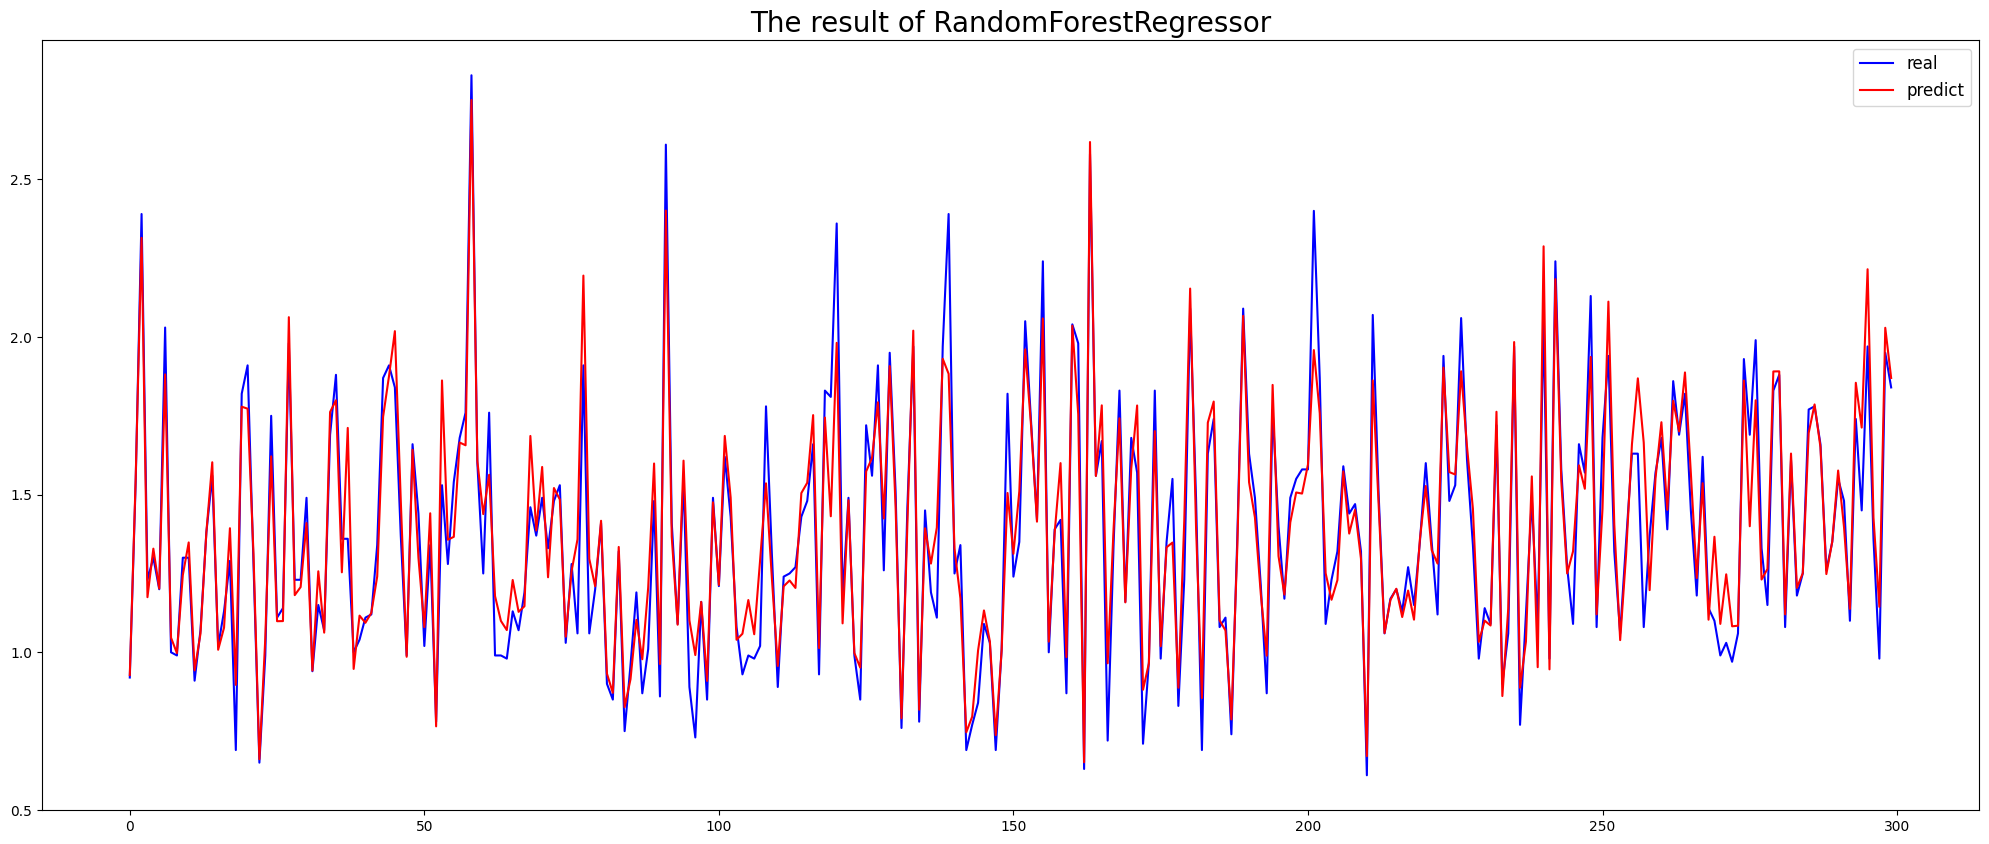

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(y_test.to_numpy(dtype=object)[:300],c='blue')
plt.plot(test_pred[:300],c='red')
plt.annotate('', xy=(50, 115), xytext=(20, 120),
arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.legend(['real','predict'],fontsize="large")
plt.title('The result of RandomForestRegressor', fontsize=20)
plt.show()

# 7. KNN

In [35]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
# Label encoding
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
# Model training
clf = LogisticRegression()
clf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
KNC = KNeighborsClassifier()
parameters={'n_neighbors': range(1,30)}
gridsearch=GridSearchCV(KNC, parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'n_neighbors': 1}

In [36]:
KNN=KNeighborsRegressor(n_neighbors=1)
KNN.fit(X_train, y_train)
pred=KNN.predict(X_test)

print("MAE",mean_absolute_error(y_test,pred))
print("MSE",mean_squared_error(y_test,pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,pred)))
print("R2",r2)

MAE 92.5770238877931
MSE 10188.225242910366
RMSE 100.93673881650014
R2 0.8900988871568283


Text(0, 0.5, 'Predicted y')

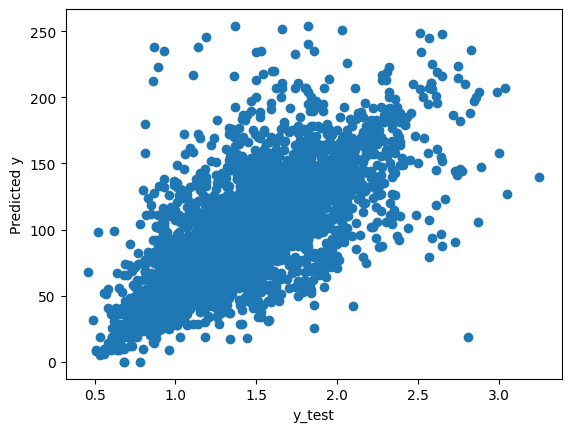

In [37]:
plt.scatter(x=y_test, y=pred)
plt.xlabel('y_test')
plt.ylabel('Predicted y')

In [38]:
#OMG there were outliers???

# 8. CatBoost

In [39]:
model = CatBoostClassifier(n_estimators=100, eval_metric = 'Accuracy')
model.fit(X_train,
       y_train,
       verbose=False,
       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
Catpreds = model.predict(X_test)
Catpreds

array([[ 45],
       [118],
       [165],
       ...,
       [139],
       [ 67],
       [ 83]], dtype=int64)

In [41]:
r2 = r2_score(y_test, Catpreds)

print("MAE",mean_absolute_error(y_test, Catpreds))
print("MSE",mean_squared_error(y_test, Catpreds))
print("RMSE",np.sqrt(mean_squared_error(y_test, Catpreds)))
print("R2",r2)

MAE 90.54036379574842
MSE 9646.371769318432
RMSE 98.21594457784556
R2 -59499.13583172761


# CNN


In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

In [43]:
erl_stop = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)

In [44]:
model = Sequential()
model.add(Dense(26, input_dim=13, activation='relu'))  #input layer
model.add(Dense(26, activation='relu'))  #hidden layer
model.add(Dense(13, activation='relu'))  #output layer

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.compile(loss='mse', optimizer='sgd', metrics=[tf.keras.metrics.MeanSquaredError()])

In [46]:
history = model.fit(X_train, y_train, epochs=1,  validation_data=(val_x, val_y), callbacks=[erl_stop])

InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Owner\AppData\Local\Temp\ipykernel_21240\757249698.py", line 1, in <module>

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 329, in fit

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 122, in one_step_on_iterator

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 72, in train_step

Incompatible shapes: [32] vs. [32,13]
	 [[{{node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_379]

In [ ]:
def plot_accuracy_loss(history):
    fig=plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(history.history['Accuracy'], 'bo--', label='acc')
    plt.plot(history.history['val_Accuracy'], 'ro--', label='val_acc')
    plt.title('train_acc VS val_acc')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend(fontsize = "large")    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title('train_loss VS val_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend()    
    plt.show()

In [ ]:
plot_accuracy_loss(history)

In [ ]:
#I realy don't like such a rough plot, maybe i'v done wrong in data preparation...
#I still had to check outliers!